<a href="https://colab.research.google.com/github/JSRist0028/animalmigration/blob/main/code/Migration_Data_Prediction_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
!pip install geopandas
!pip install shapely

In [181]:
import pandas as pd
import sklearn.preprocessing
import sklearn.manifold 
import matplotlib.pyplot as plt
import numpy as np
import math

**Change the csv file and whether or not to include temperature here:**

In [182]:
# import data with combined temperature and tracking information

data_raw = pd.read_csv('https://github.com/JSRist0028/animalmigration/blob/main/data/barnacle_geese_data_matrix?raw=true')

# geese data: ('https://github.com/JSRist0028/animalmigration/blob/main/data/barnacle_geese_data_matrix?raw=true')
# whale data: ('https://raw.githubusercontent.com/JSRist0028/animalmigration/main/data/Azores%20Great%20Whales%20Satellite%20Telemetry%20Program%20.csv')


includeTemp = True; 
data_raw

,row number,timestamp,latitude,longitude,height,speed,heading,birdID,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,station_lat,station_long
0,0,2009-02-10 10:00:00,53.38117,6.10583,1.0,0.0,51.0,78033,1.8,0.6,3.1,NaN,NaN,286.7,22.2,NaN,NaN,NaN,53.4167,6.2000
1,1,2009-02-10 15:00:00,53.39283,6.18700,1.0,1.0,351.0,78033,1.8,0.6,3.1,NaN,NaN,286.7,22.2,NaN,NaN,NaN,53.4167,6.2000
2,2,2009-02-11 10:00:00,53.40483,6.15600,1.0,0.0,98.0,78033,1.9,0.8,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.4167,6.2000
3,3,2009-02-11 15:00:00,53.40250,6.15683,1.0,0.0,153.0,78033,1.9,0.8,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.4167,6.2000
4,4,2009-02-12 10:00:00,53.36217,6.13750,1.0,0.0,61.0,78033,2.1,1.0,3.9,NaN,NaN,242.1,25.5,NaN,NaN,NaN,53.4167,6.2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21097,21097,2009-06-21 15:00:00,60.31100,27.08550,1.0,0.0,59.0,78042b,14.7,11.3,18.8,NaN,NaN,NaN,4.8,NaN,1026.1,NaN,60.2833,27.1833
21098,21098,2009-06-22 06:00:00,60.31100,27.08567,1.0,0.0,328.0,78042b,17.5,13.5,21.2,NaN,NaN,145.0,8.3,NaN,1027.1,NaN,60.2833,27.1833
21099,21099,2009-06-22 09:00:00,60.31100,27.08567,1.0,0.0,222.0,78042b,17.5,13.5,21.2,NaN,NaN,145.0,8.3,NaN,1027.1,NaN,60.2833,27.1833
21100,21100,2009-06-22 12:00:00,60.31100,27.08550,1.0,0.0,6.0,78042b,17.5,13.5,21.2,NaN,NaN,145.0,8.3,NaN,1027.1,NaN,60.2833,27.1833


In [183]:
# creates dataframe with only unique dates

def date_to_nth_day(date):#, format='%Y%m%d'):
    date = pd.to_datetime(date)#, format=format)
    new_year_day = pd.Timestamp(year=date.year, month=1, day=1)
    return (date - new_year_day).days + 1
# source: https://codereview.stackexchange.com/questions/154140/interpret-yyyymmdd-as-the-nth-day-of-the-year


# create a new DataFrame with only location data from unique days
data = pd.DataFrame(columns=data_raw.columns) # create header
for i, row in data_raw.iterrows():
  if i>0: # skip first row
    if (date_to_nth_day(row['timestamp']) != date_to_nth_day(data_raw['timestamp'][i-1])): 
      data = data.append(row, ignore_index=True)
      #print(i)

In [184]:
# used for geese to eliminate characters in birdID

data['birdID'][5800].replace('a', '2')

'780422'

In [185]:
# Splits data into features (today) and targets (tomorrow)

def get_todaytomorrow(data, includeTemp):
  num_rows = len(data)
  if includeTemp:
    today = np.empty((0,7), dtype='float')#, 'int') #[]
  else:
    today = np.empty((0,4), 'int') #[]
  tomorrow = np.empty((0,3), dtype='float') #, 'int') #[]
  for i, row in data.iterrows():
    if (i<(num_rows-3)):
      if (pd.notnull(row['tavg']) & pd.notnull(data['tavg'][i+1])): # only add pair if both contain basic weather data (avg temp)
        if (data['birdID'][i]==data['birdID'][i+1]):                # only add if birdIDs match
          today_day = date_to_nth_day(row['timestamp'])
          tomorrow_day = date_to_nth_day(data['timestamp'][i+1])
#          if (tomorrow_day-today_day == 1):                         # makes sure that the days are consecutive -> already done ^
          birdID_today = row['birdID'].replace('a','1')
          birdID_today = birdID_today.replace('b', '2')
          birdID_tomorrow = data['birdID'][i+1].replace('a','1')
          birdID_tomorrow = birdID_tomorrow.replace('b','2')
          if includeTemp:
            today_entry = np.asarray([int(birdID_today), today_day, row['latitude'], row['longitude'], row['tavg'], row['tmin'], row['tmax'] ])
            tomorrow_entry = np.asarray([int(birdID_tomorrow), data['latitude'][i+1], data['longitude'][i+1]]) #no change
          else:
            today_entry = np.asarray([int(birdID_today), today_day, row['latitude'], row['longitude']])
            tomorrow_entry = np.asarray([int(birdID_tomorrow), data['latitude'][i+1], data['longitude'][i+1]]) # no change
          today_entry[np.isnan(today_entry)]=0
          tomorrow_entry[np.isnan(tomorrow_entry)]=0
          today = np.vstack((today,today_entry))
          tomorrow = np.vstack((tomorrow, tomorrow_entry))
         #print(i)
  return today, tomorrow

today, tomorrow = get_todaytomorrow(data, includeTemp=includeTemp)

In [186]:
# Split the data into training and testing sets
features = today[:,1:] #data.values[:,:-1]
labels = tomorrow[:,1:] #[:,[1,2]] #data.values[:, 60]
#features = features.reshape(features.shape[0], features.shape[1], 1) if using CNN, may need to use this
import math
# Split the data into training and testing sets cronologically

todaydf = pd.DataFrame(today)
tomorrowdf = pd.DataFrame(tomorrow)

def train_test_split(datafile, tomorrow, train_ratio):
    
    # Define dataframes to return
    
    xheaders = ['AnimalID', 'TS', 'Lat - 1', 'Long - 1']
    yheaders = ['AnimalID', 'Lat', 'Long']
    
    trainx = pd.DataFrame(columns = xheaders)
    trainy = pd.DataFrame(columns = yheaders)
    testx = pd.DataFrame(columns = xheaders)
    testy = pd.DataFrame(columns = yheaders)
    
    # Split each unique animal tracking info into training and testing sets
    
    for animal in datafile[0].unique():
        traincount = math.ceil(float(datafile[datafile[0] == animal].shape[0]) * train_ratio)
        obscount = datafile[datafile[0] == animal].shape[0]
        obslist = datafile.index[datafile[0] == animal].tolist()
        
        for obs in range(0, traincount, 1):
            dfx = [animal, datafile[1][obslist[obs]], datafile[2][obslist[obs]], datafile[3][obslist[obs]]]
            dfy = [animal, tomorrow[1][obslist[obs]], tomorrow[2][obslist[obs]]]
            
            trainx.loc[len(trainx.index)] = dfx
            trainy.loc[len(trainy.index)] = dfy

        for obs in range(traincount, obscount, 1):
            dfx = [animal, datafile[1][obslist[obs]], datafile[2][obslist[obs]], datafile[3][obslist[obs]]]
            dfy = [animal, tomorrow[1][obslist[obs]], tomorrow[2][obslist[obs]]]
            
            testx.loc[len(testx.index)] = dfx
            testy.loc[len(testy.index)] = dfy
    
    return(trainx, trainy, testx, testy)

trainin_x, trainin_y, testin_x, testin_y = train_test_split(todaydf, tomorrowdf, 0.8)



In [187]:
# converts data into correct type for keras model

training_x = np.transpose(np.asarray([trainin_x['TS'], trainin_x['Lat - 1'], trainin_x['Long - 1']]).astype('float32'))
training_y = np.transpose(np.asarray([trainin_y['Lat'], trainin_y['Long']]).astype('float32'))
testing_x = np.transpose(np.asarray([testin_x['TS'], testin_x['Lat - 1'], testin_x['Long - 1']]).astype('float32'))
testing_y = np.transpose(np.asarray([testin_y['Lat'], testin_y['Long']]).astype('float32'))
# from https://stackoverflow.com/questions/48851558/tensorflow-estimator-valueerror-logits-and-labels-must-have-the-same-shape

# Regression Model 

In [188]:
# Regression packages
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers.experimental import preprocessing

In [189]:
# Normalization 
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(training_x))

# Build model, add layers
input_size = training_x.shape[1]
my_model = Sequential([normalizer, Dense(units=1)])
my_model.add(Dense(32, input_dim=input_size, kernel_initializer='normal', activation='relu'))
#my_model.add(Conv1D(32, 3, activation="relu"))
my_model.add(Dense(16,  kernel_initializer='normal', activation='relu'))
#my_model.add(Dense(16,  kernel_initializer='normal', activation='relu'))
my_model.add(Dense(8,  kernel_initializer='normal', activation='relu'))
my_model.add(Dense(2, kernel_initializer='normal'))


In [190]:
# Train model

from tensorflow import optimizers
my_model.compile(optimizer=optimizers.Adam(learning_rate=0.1),loss='mean_absolute_error')
history = my_model.fit(training_x, training_y,epochs=50,verbose=0,validation_split = 0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
45,1.129186,0.977685,45
46,0.891355,0.730096,46
47,1.111396,2.657856,47
48,1.212151,0.918625,48
49,0.926179,1.099914,49


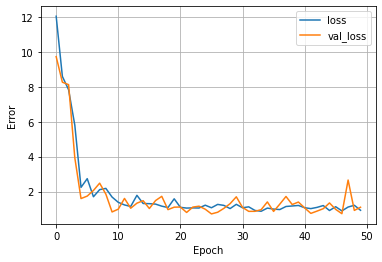

In [191]:
# Plot loss by Epoch to evaluate model improvement

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [192]:
my_model.evaluate(testing_x,testing_y, verbose=0)

1.1125404834747314

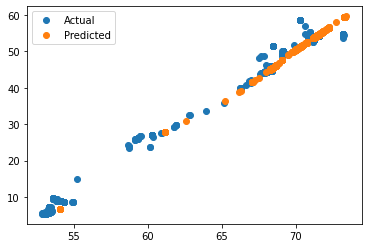

In [193]:
# Make predictions 

train_predictions = my_model.predict(training_x)#.flatten()
test_predictions = my_model.predict(testing_x)#.flatten()

test_predictions
fig,ax = plt.subplots()

ax.plot(testing_y[:,0], testing_y[:,1], 'o', label='Actual')
ax.plot(test_predictions[:,0], test_predictions[:,1], 'o', label='Predicted')
ax.legend()

Mean testing error: 1.746028184890747
Mean training error: 1.7787126302719116


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


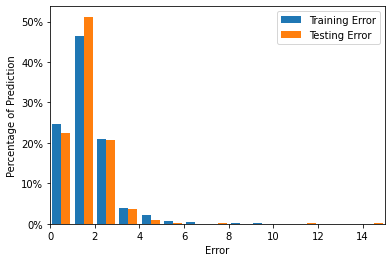

In [194]:
testing_error = np.sqrt((test_predictions[:,0] - testing_y[:,0])**2 + (test_predictions[:,1] - testing_y[:,1])**2)
training_error = np.sqrt((train_predictions[:,0] - training_y[:,0])**2 + (train_predictions[:,1] - training_y[:,1])**2)
# need to change this to account for lat/long to get real distance between points

print(f'Mean testing error: {np.mean(testing_error)}')
print(f'Mean training error: {np.mean(training_error)}')

#fig = plt.figure()
#ax = plt.axes(projection='3d')
#ax.scatter3D(training_y[:,0],training_y[:,1], training_error, label='Training Error', marker='x', depthshade=False)
#ax.scatter3D(testing_y[:,0],testing_y[:,1], testing_error,label='Testing Error', marker='x',depthshade=False)
#ax.legend()

from matplotlib.ticker import PercentFormatter
bins_list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
fig = plt.figure()
plt.hist([training_error, testing_error], bins=bins_list, label=['Training Error', 'Testing Error'], weights=[np.ones(len(training_error))/len(training_error), np.ones(len(testing_error))/len(testing_error)])
#plt.hist(training_error, weights=np.ones(len(training_error))/len(training_error), label='Training Error', bins=bins_list )
#plt.hist(testing_error, weights=np.ones(len(testing_error))/len(testing_error), label='Testing Error',bins=bins_list)

plt.xlabel('Error')
plt.ylabel('Percentage of Prediction')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlim(0,15)
plt.legend()

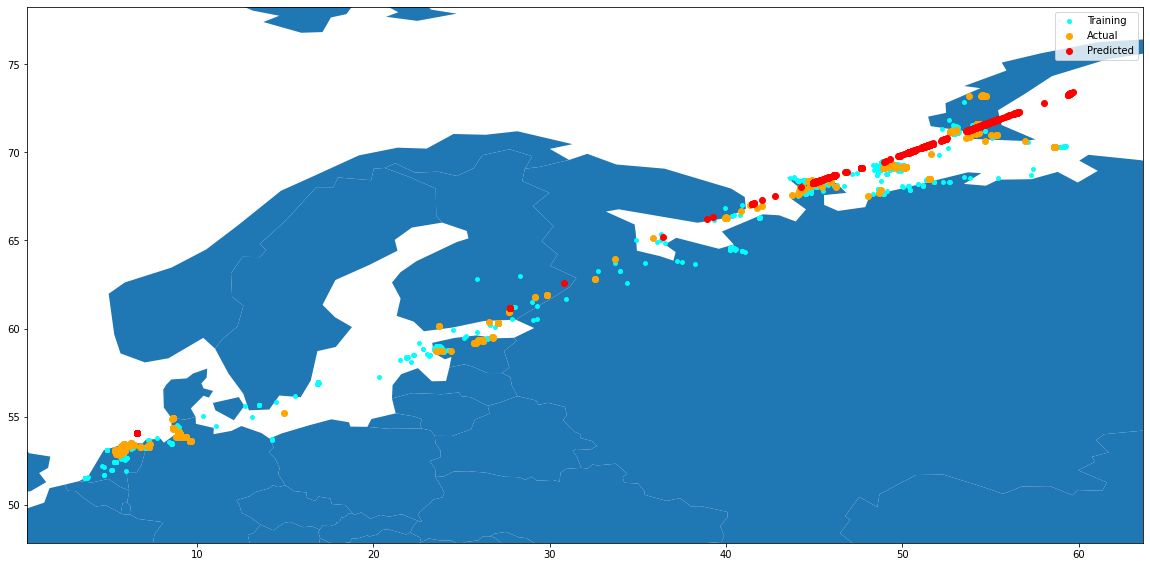

In [195]:
# Plot prediction on map 

from shapely.geometry import Point, LineString, MultiPoint
import geopandas as gpd
from geopandas import GeoDataFrame

actual_plot=gpd.GeoDataFrame([[MultiPoint(np.flip(testing_y, axis=1))]],columns=['geometry'])
predicted_plot=gpd.GeoDataFrame([[MultiPoint(np.flip(test_predictions, axis=1))]],columns=['geometry'])
training_plot = gpd.GeoDataFrame([[MultiPoint(np.flip(training_y, axis=1))]], columns=['geometry'])
minx, miny, maxx, maxy = actual_plot.geometry.total_bounds

fig, ax = plt.subplots(figsize=(20,12))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world.plot(ax=ax)
training_plot.plot(ax=ax,marker='o',label='Training', color='cyan', markersize=15)
actual_plot.plot(ax=ax, marker='o', label='Actual', color='orange')
predicted_plot.plot(ax=ax,marker='o',label='Predicted', color='red')

ax.set_xlim(minx - 5, maxx + 5) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 5, maxy + 5)
ax.legend()
#https://gis.stackexchange.com/questions/332624/geopandas-plot-two-layers-but-only-to-the-extent-of-the-smaller-one

# Predicting a Full year of Migratory Patterns

In [196]:

longtest_x = testing_x
longtest_y = my_model.predict([longtest_x[:][0].tolist()])

for rows in range(1, len(testin_x), 1):
  predict = my_model.predict([longtest_x[:][rows].tolist()])
  longtest_y = np.vstack((longtest_y, predict))

  if len(testin_x) > rows + 1:
    if testin_x['AnimalID'][rows] == testin_x['AnimalID'][rows + 1]:
      longtest_x[rows + 1, 1] = predict[0][0]
      longtest_x[rows + 1, 2] = predict[0][1]


In [197]:
longtest_y

array([[68.326546, 45.11457 ],
       [68.31785 , 45.089504],
       [68.56155 , 45.79162 ],
       ...,
       [61.173363, 27.729843],
       [61.173363, 27.729843],
       [61.173363, 27.729843]], dtype=float32)

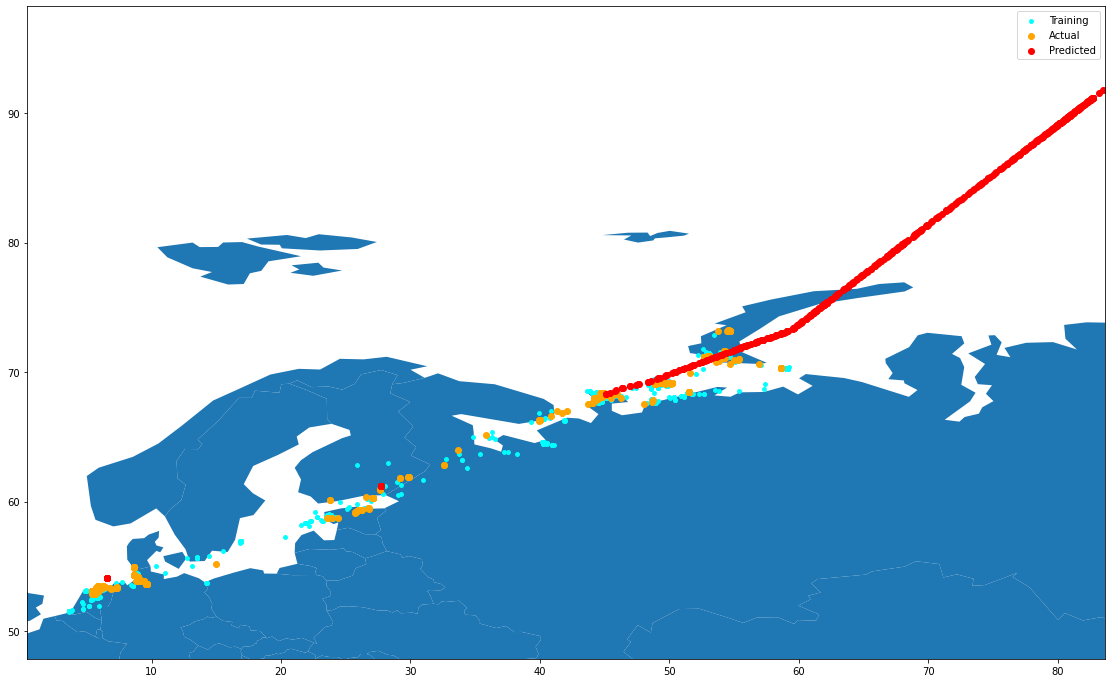

In [198]:
# Plot updated prediction on map 

actual_plot=gpd.GeoDataFrame([[MultiPoint(np.flip(testing_y, axis=1))]],columns=['geometry'])
predicted_plot=gpd.GeoDataFrame([[MultiPoint(np.flip(longtest_y, axis=1))]],columns=['geometry'])
training_plot = gpd.GeoDataFrame([[MultiPoint(np.flip(training_y, axis=1))]], columns=['geometry'])
minx, miny, maxx, maxy = actual_plot.geometry.total_bounds

fig, ax = plt.subplots(figsize=(20,12))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world.plot(ax=ax)
training_plot.plot(ax=ax,marker='o',label='Training', color='cyan', markersize=15)
actual_plot.plot(ax=ax, marker='o', label='Actual', color='orange')
predicted_plot.plot(ax=ax,marker='o',label='Predicted', color='red')

ax.set_xlim(minx - 5, maxx + 25) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 5, maxy + 25)
ax.legend()
#https://gis.stackexchange.com/questions/332624/geopandas-plot-two-layers-but-only-to-the-extent-of-the-smaller-one